<h3>Deep learning forecasting on Bitcoin with LSTM</h3>

The goal of this notebook is to try to forecast the Bitcoin price for the next 6 months.

Cryptocurrencies are a very difficult type of time serie to predict because they cannot be described purely by their price, it is obvious that the predictions will be wrong.

In [27]:
import pandas as pd
import numpy as np

input_df = pd.read_csv(r'btc-price.csv')
input_df.Date = pd.to_datetime(input_df.Date)
input_df = input_df.set_index('Date')
input_df = input_df.fillna(method='backfill')
print('Number of NaN values:\n' + str(input_df.isnull().sum()))
input_df.tail(10)

Number of NaN values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,51514.812500,3.587390e+10
2021-10-06,51486.664063,55568.464844,50488.191406,55361.449219,55361.449219,4.903473e+10
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,53805.984375,3.680786e+10
2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,53967.847656,3.480087e+10
2021-10-09,53929.781250,55397.945313,53735.144531,54968.222656,54968.222656,3.249121e+10
2021-10-10,54952.820313,56401.304688,54264.257813,54771.578125,54771.578125,3.952779e+10
2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,4.263733e+10
2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,56041.058594,4.108376e+10
2021-10-13,56038.257813,57688.660156,54370.972656,57401.097656,57401.097656,4.168425e+10


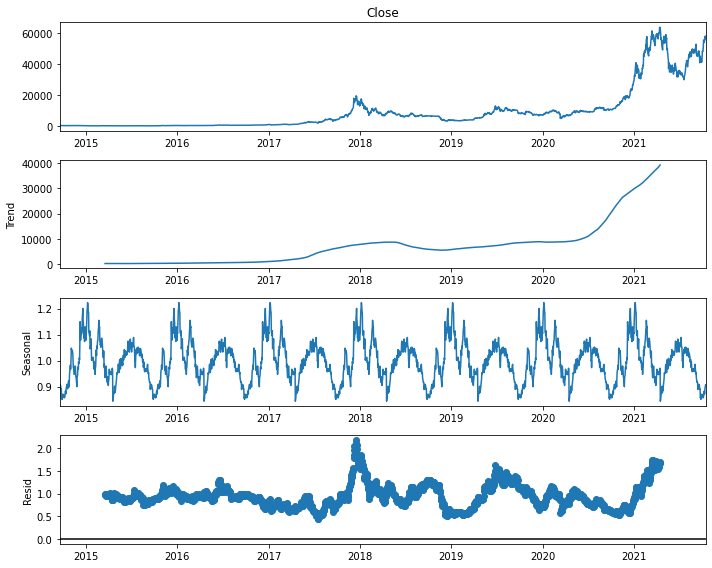

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(input_df['Close'], model='multiplicative', period = 365)
plt.rcParams["figure.figsize"] = (10,8)
result.plot()
plt.show()

We can observe that the trend is constantly rising and the seasonality is clearly defined with peaks toward January and June.

But there are also noises toward December 2018 and 2021, which mean there are other factors that influenced these periods.

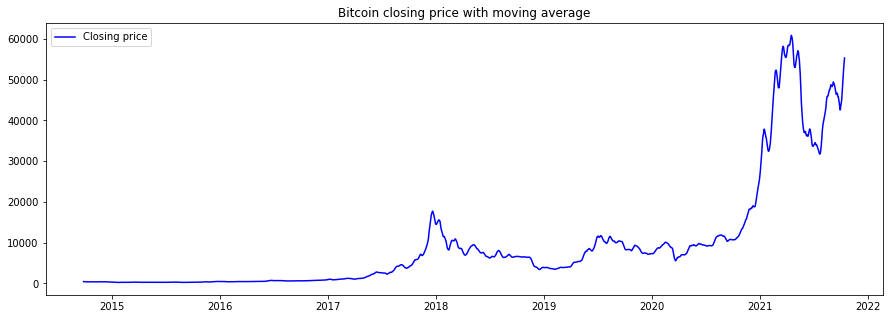

In [29]:
window_size = 10
input_df = input_df.rolling(window=window_size, center=False).mean()
#Moving Average based on the last 10 days

plt.figure(figsize=(15, 5))
plt.plot(input_df['Close'], color='b', label='Closing price')
#plt.plot(input_df['Close_MA'], color='b', label='Moving average')
plt.title('Bitcoin closing price with moving average')
plt.legend()

The moving average is useful when making predictions because it lower the noise of the data, thus making it more reliable.

We will only be using the closing price to begin with.

In [30]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

n_futur = 120 # Number of days we want to predict into the future.
n_past = 120 # Number of past days we want to use to predict future.

sc = MinMaxScaler(feature_range=(0,1))

df_train= input_df[['Close']][window_size:-n_futur].values
print(df_train.shape)
df_test= input_df[['Close']][-n_futur:].values
print(df_test.shape)

date_train = input_df[window_size:-n_futur].index
date_test = input_df[-n_futur:].index

df_train = sc.fit_transform(df_train)

BATCH_SIZE = 512
train_generator = TimeseriesGenerator(df_train, df_train,  length=n_past, batch_size=BATCH_SIZE)

(2455, 1)
(120, 1)


In [31]:
import tensorflow as tf
from keras import models
from keras import layers

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True),input_shape=(None, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20)
])

lstm_model.summary()

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, None, 256)         133120    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 532,500
Trainable params: 532,500
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_model.fit(train_generator, epochs = 50)

lstm_model.save_weights('LSTM_weigth.h5')

Epoch 1/50
5/5 [==============================] - 7s 441ms/step - loss: 0.0481
Epoch 2/50
5/5 [==============================] - 2s 434ms/step - loss: 0.0170
Epoch 3/50
5/5 [==============================] - 2s 435ms/step - loss: 0.0131
Epoch 4/50
5/5 [==============================] - 2s 432ms/step - loss: 0.0136
Epoch 5/50
5/5 [==============================] - 2s 434ms/step - loss: 0.0052
Epoch 6/50
5/5 [==============================] - 2s 433ms/step - loss: 0.0148
Epoch 7/50
5/5 [==============================] - 2s 495ms/step - loss: 0.0077
Epoch 8/50
5/5 [==============================] - 2s 433ms/step - loss: 0.0102
Epoch 9/50
5/5 [==============================] - 2s 434ms/step - loss: 0.0035
Epoch 10/50
5/5 [==============================] - 3s 586ms/step - loss: 0.0054
Epoch 11/50
5/5 [==============================] - 2s 482ms/step - loss: 0.0024
Epoch 12/50
5/5 [==============================] - 2s 441ms/step - loss: 0.0025
Epoch 13/50
5/5 [==============================] 

In [33]:
lstm_model.load_weights('LSTM_weigth.h5')

In [34]:
def predict(num_prediction, model):
    prediction_list = df_train[-n_past:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_past:]
        x = x.reshape(1, n_past, 1)
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_past-1:]
        
    return prediction_list

def predict_dates(num_prediction):
    prediction_dates = pd.date_range(date_train[-1], periods=num_prediction+1, freq='1D').tolist()
    return prediction_dates

forecast = predict(n_futur, lstm_model).reshape(-1, 1)
print(forecast.shape)
forecast = sc.inverse_transform(forecast)
date_forecast = predict_dates(n_futur)
print(forecast.shape)

(121, 1)
(121, 1)


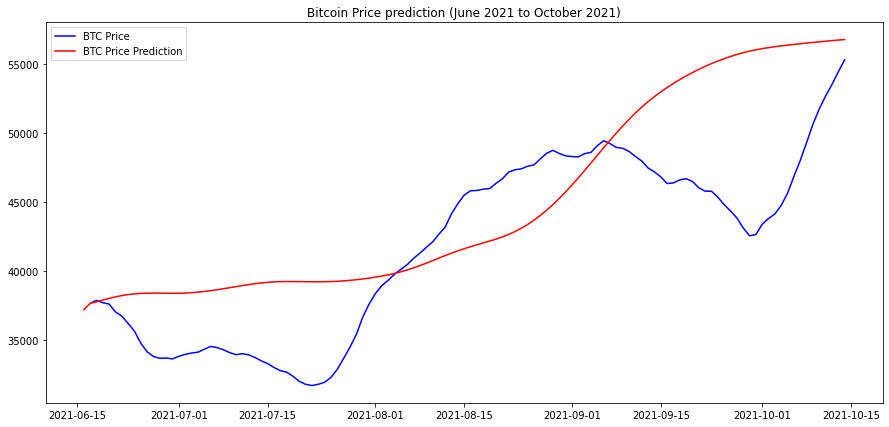

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(date_test, df_test, color='b', label='BTC Price')
plt.plot(date_forecast, forecast, color='red', label='BTC Price Prediction')
plt.title('Bitcoin Price prediction (June 2021 to October 2021)')
plt.legend()

Each subdivisions correspond to one day, here we have 6 months of prediction.

The model did understand the rising tendency but won't be really accurate.

Next we will train the model to predict the futur beyond the dataset.

In [44]:
df_train= input_df[['Close']][window_size:].values
date_train = input_df[['Close']][window_size:].index

df_train = sc.fit_transform(df_train)

train_generator = TimeseriesGenerator(df_train, df_train,  length=n_past)

In [45]:
lstm_model.fit(train_generator, epochs = 50)

Epoch 1/25
20/20 [==============================] - 3s 129ms/step - loss: 0.0010
Epoch 2/25
20/20 [==============================] - 3s 132ms/step - loss: 7.8164e-04
Epoch 3/25
20/20 [==============================] - 4s 178ms/step - loss: 0.0010
Epoch 4/25
20/20 [==============================] - 3s 128ms/step - loss: 9.8448e-04
Epoch 5/25
20/20 [==============================] - 3s 175ms/step - loss: 9.9872e-04
Epoch 6/25
20/20 [==============================] - 4s 177ms/step - loss: 0.0026
Epoch 7/25
20/20 [==============================] - 3s 167ms/step - loss: 8.3372e-04
Epoch 8/25
20/20 [==============================] - 3s 174ms/step - loss: 7.2158e-04
Epoch 9/25
20/20 [==============================] - 3s 136ms/step - loss: 6.4155e-04
Epoch 10/25
20/20 [==============================] - 3s 176ms/step - loss: 8.3764e-04
Epoch 11/25
20/20 [==============================] - 4s 222ms/step - loss: 8.2193e-04
Epoch 12/25
20/20 [==============================] - 4s 219ms/step - loss: 

In [46]:
forecast = predict(n_futur, lstm_model).reshape(-1, 1)
forecast = sc.inverse_transform(forecast)
date_forecast = predict_dates(n_futur)
df_train = sc.inverse_transform(df_train)
print(forecast.shape)

(121, 1)


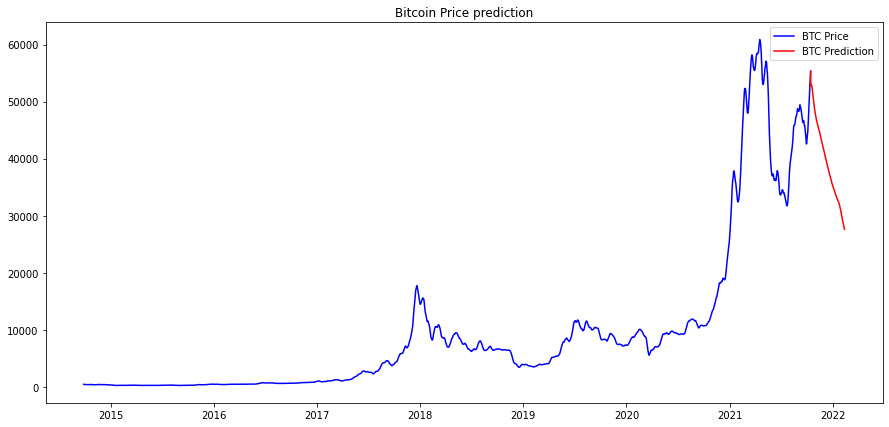

In [47]:
plt.figure(figsize=(15, 7))
plt.plot(date_train, df_train, color='blue', label='BTC Price')
plt.plot(date_forecast, forecast, color='red', label='BTC Prediction')
plt.title('Bitcoin Price prediction')
plt.legend()

I don't think this is a good prediction... But we'll see !

Time series tends to overfit very easily.

Thank you for watching my messy attempt at predicting anything from a time serie.